### 1. DB에서 필요한 데이터들 불러오기

In [2]:
import pymysql
import pandas as pd

In [145]:
con = pymysql.connect(
    host='localhost',
    user='root',
    password='1111',
    db='beaulol',
    charset='utf8'
)

customer_type_df = pd.read_sql("SELECT userID, user_skintype,user_trouble FROM customer_type", con)
customer_regis_df = pd.read_sql("SELECT userID, prd_brand, prd_name FROM customer_regis", con)
product_info_df = pd.read_sql("SELECT prd_name, prd_brand, prd_ingredients, prd_category FROM product_info", con)
solvent_df = pd.read_sql("SELECT ingredient_kor FROM solvent", con)

con.close()

C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\896438246.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_type_df = pd.read_sql("SELECT userID, user_skintype,user_trouble FROM customer_type", con)
C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\896438246.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_regis_df = pd.read_sql("SELECT userID, prd_brand, prd_name FROM customer_regis", con)
C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\896438246.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy

In [146]:
customer_type_df.head()

,userID,user_skintype,user_trouble
0,F0002,건성,민감성/아토피
1,F0003,복합성,주름/탄력
2,F0004,중성,잡티/미백/홍조/다크서클
3,F0005,건성,각질
4,F0006,중성,트러블


In [147]:
customer_regis_df.head()

,userID,prd_brand,prd_name
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼
2,F0002,라운드랩,1025 독도 토너
3,F0002,아벤느,트릭세라 로션
4,F0002,에스트라,아토베리어365 하이드로 수딩크림


In [148]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"정제수, 나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, ...",세럼
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1,2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1,2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너


### 2. 전처리
    [콤마 포함한 성분 이름 변경]
    1) 모든 '화장품 원료'(from 화장품원료.csv) 중에 콤마가 들어가 성분 추출
    2) product_info_df안에 콤마포함성분 확인 -> 4가지 성분 확인
    3) 콤마포함성분을 슬래시로 변경

----
    [구분자 변경 & 괄호 제거]
    우선 (콤마 스페이스, 콤마, 스페이스)로 나눠진 데이터가 가장 많다. 하지만 스페이스와 콤마는 후에 성분내에 ex) 레티놀 (500IU/g), 쏼라쏼라(100,000ppm) 콤마와 스페이스를 넣어놓은 곳이 있기 때문에 나중에 세부 처리.
    1) 이 세 구분자를 제외한 구분자 모두 콤마 스페이스(, )로 변경
    2) 성분뒤 괄호안 내용 다 제거 (정규표현식 이용)

    3) 콤마스페이스로 구분되지않은 nd_product_info_df 생성 >> 81행 발견
    이유: 스페이스나 콤마로 구분자가 많아서 그렇다.
    4) 콤마나 스페이스 구분자를, 콤마 스페이스 구분자로 변경 
    5) 그래도 이상한 이상치들 확인. 15개 성분데이터는 '-'대시로 변경하여 머신러닝 영향을 최소화
    6) nd_product_info_df 를 원본 데이터프레임과 합침.

    product_info_df의 전처리 끝
------
    [용매와 방부제 역할을 하는 성분 제거 후, 새로운 열 'main_prd_ingredients' 생성]
    1) solvent df에서 성분안에 콤마를 가진 성분 슬래쉬로 변경후, 리스트로 정리
    2) solvent 성분을 'prd_ingredients'에서 제거후, 'main_prd_ingredients'에 저장
-----
    [유저별 화장품 목록, 화장품 성분 목록 생성]
    - 유저별로 화장품 목록과 화장품 성분목록을 묶어서 만든 뒤, 최종 셋팅 완료된 데이터를 csv 파일로 저장.

In [149]:
'''
구분자 종류:
1) 스페이스바( )
2) 콤마 스페이스(, )
3) 콤마(,)
3) 온점 스페이스(. )
4) 골뱅이(@)
5) 별 콤마(*.)
6) 별 골뱅이(*@)
7) 별 (*)
'''

'\n구분자 종류:\n1) 스페이스바( )\n2) 콤마 스페이스(, )\n3) 콤마(,)\n3) 온점 스페이스(. )\n4) 골뱅이(@)\n5) 별 콤마(*.)\n6) 별 골뱅이(*@)\n7) 별 (*)\n'

In [150]:
# 모든 성분들 이름 불러오기
all_ingred = pd.read_csv('./files/화장품원료.csv')
all_ingred.head()

,INGR_KOR_NAME,INGR_ENG_NAME,CAS_NO,ORIGIN_MAJOR_KOR_NAME,INGR_SYNONYM
0,가공소금,NaN,NaN,NaN,NaN
1,가지열매추출물,Solanum Melongena (Eggplant) Fruit Extract,84012-19-1,이 원료는 가지(Eggplant) Solanum melongena의 열매에서 추출한...,가지추출물
2,구멍쇠미역추출물,Agarum Cribrosum Extract,NaN,이 원료는 조류의 일종인 구멍쇠미역 Agarum cribosum에서 추출한 것이다.,NaN
3,루핀아미노산,Lupine Amino Acids,NaN,이 원료는 루핀 단백질의 완전 가수분해로 얻은 아미노산의 혼합물이다.,NaN
4,류신,Leucine,"328-39-2(DL-)\r,61-90-5(L-)",이 원료는 다음의 구조를 갖는 아미노산이다.,NaN


In [151]:
# 콤마를 가진 성분들 저장하기
comma_inged = all_ingred[all_ingred['INGR_KOR_NAME'].str.contains(',')==True]['INGR_KOR_NAME']
comma_inged.head()

629                5-브로모-5-나이트로-1,3-디옥산
630              2-브로모-2-나이트로프로판-1,3-디올
2035                  에틸2,2-다이메틸하이드로신남알
2524    4,4'-아이소프로필리덴다이페놀/에피클로로하이드린코폴리머
3666                         1,10-데칸다이올
Name: INGR_KOR_NAME, dtype: object

In [152]:
# 콤마 포함된 성분들
for x in comma_inged:
    matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]
    if not matching_rows.empty:
        print(x)
        display(matching_rows)
# 결과: 4개의 성분이 성분들 나누기를 방해하고 있다.
# 1,2-헥산다이올, 2-올레아미도-1,3-옥타데칸다이올, 2,3-부탄다이올, 2,4-다이메틸-3-사이클로헥신카복스알데하이드

1,2-헥산다이올


,prd_name,prd_brand,prd_ingredients,prd_category
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1,2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1,2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너
5,3번 결광가득 에센스 토너,넘버즈인,"정제수, 다이프로필렌글라이콜, 글리세레스-26, 1,2-헥산다이올, 나이아신아마이드...",스킨토너
...,...,...,...,...
432,히알루로닉 에센스,로벡틴,"정제수, 글리세린, 메틸글루세스-20, 펜틸렌글라이콜, 부틸렌글라이콜, 나이아신아마...",세럼
433,히알루론산 레이어 물톡스 앰플,메디필,"정제수, 프로판다이올, 글리세린, 다이프로필렌글라이콜, 메틸프로판다이올, 1,2-헥...",세럼
434,히알루론산 레이어 물톡스 앰플 더블 기획,메디필,"정제수, 프로판다이올, 글리세린, 다이프로필렌글라이콜, 메틸프로판다이올, 1,2-헥...",세럼
435,힐러 턴오버 액티브 크림,리쥬란,"정제수, 글리세린, 부틸렌글라이콜, 메틸하이드로제네이티드로지네이트, 다이프로필렌글라...",크림


2-올레아미도-1,3-옥타데칸다이올


,prd_name,prd_brand,prd_ingredients,prd_category
183,비오템옴므 아쿠아파워 어드밴스드 젤 로션 100ML,비오템 옴므,정제수 다이메티콘 변성알코올 글리세린 부틸렌글라이콜 시어버터 암모늄폴리아크릴로일다이...,로션


2,3-부탄다이올


C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\1074179305.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]


,prd_name,prd_brand,prd_ingredients,prd_category
39,노스카나인 트러블 클리어 토너,파티온,"정제수, 2,3-부탄다이올, 에톡시다이글라이콜, 글루코노락톤, 1,2-헥산다이올, ...",스킨토너
43,다이브인 저분자 히알루론산 수딩 크림,토리든,"정제수, 부틸렌글라이콜, 글리세린, 1,2-헥산다이올, 하이드로제네이티드다이데센, ...",크림
45,다이브인 저분자 히알루론산 토너,토리든,"정제수, 부틸렌글라이콜, 다이프로필렌글라이콜, 1,2-헥산다이올, 글리세린, 베타인...",스킨토너
58,데일리뮨 앰플 세럼,피지오겔,"정제수, 다이프로필렌글라이콜, 프로판다이올, 아스코빅애씨드, 2,3-부탄다이올, 글...",세럼
71,레드 블레미쉬 클리어 모이스처 크림,닥터지,"정제수, 글리세린, 2,3-부탄다이올, 하이드로제네이티드폴리(C6-14올레핀), 병...",크림
109,리큐어 노르데나우 시카에센스,케어존,"정제수, 글리세린, 2,3-부탄다이올, 사이클로펜타실록세인, 다이메티콘, 1,2-헥...",세럼
118,마이크로액티브 브라이트닝 앰플,숨37,"정제수*, 글리세린, 부틸렌글라이콜*, 소듐아스코빌포스페이트*, 2,3-부탄다이올*...",세럼
119,마이크로액티브 카밍 앰플,숨37,"정제수*, 변성알코올, 2,3-부탄다이올*, 글리세린*, 세린*, 1,2-헥산다이올...",세럼
140,미라클 토닝 글로우 세럼,오휘,"정제수, 프로판다이올, 글리세린, 2,3-부탄다이올, 펜틸렌글라이콜, 나이아신아마이...",세럼
196,사이언수티컬즈 데일리뮨 앰플세럼,피지오겔,"정제수, 다이프로필렌글라이콜, 프로판다이올, 아스코빅애씨드, 2,3-부탄다이올, 글...",세럼


2,4-다이메틸-3-사이클로헥신카복스알데하이드


C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\1074179305.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]


,prd_name,prd_brand,prd_ingredients,prd_category
29,그린토마토 포어 리프팅 앰플 플러스,성분에디터,"정제수, 부틸렌글라이콜, 글리세린, 자일리톨, 1,2-헥산다이올, 나이아신아마이드,...",세럼


C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\1074179305.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_rows = product_info_df[product_info_df['prd_ingredients'].str.contains(x)]


In [153]:
# 4개 성분 이름 안 콤마를 슬래쉬(/)로 변경
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('1,2-헥산다이올', '1/2-헥산다이올')
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('2-올레아미도-1,3-옥타데칸다이올', '2-올레아미도-1/3-옥타데칸다이올')
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('2,3-부탄다이올', '2/3-부탄다이올')
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].str.replace('2,4-다이메틸-3-사이클로헥신카복스알데하이드', '2/4-다이메틸-3-사이클로헥신카복스알데하이드')

* 구분자 변경

In [154]:
# 우선 구분자 수정> ', '로
import re
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x: re.sub(r'\. |@|\*\.|\*,|\*@|\*', ', ', x))

# nd_product_info_df['prd_ingredients'] = nd_product_info_df['prd_ingredients'].str.replace('. ', ', ').str.replace('@', ', ').str.replace('*.', ', ').str.replace('*,',', ').str.replace('*@', ', ')

In [155]:
# 'prd_ingredients' 열의 문자열에서 괄호와 괄호 안의 내용을 제거

product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x:\
    re.sub(r'\(.*?\)', '', x))

In [156]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"정제수, 나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, ...",세럼
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너


In [157]:
# 콤마 스페이스로 구분 되지 않는 것들
nd_product_info_df = product_info_df[product_info_df['prd_ingredients'].str.split(', ').apply(len) == 1]

display(product_info_df[product_info_df['prd_ingredients'].str.split(', ').apply(len) == 1])
nd_product_info_df.info()
# 81개의 행이 이상.. 스페이스와 콤마로만 구분하는 구분자 존재. 

# product_info_df[len(product_info_df['prd_ingredients'].str.split(','))==1]
# 오류나는 이유??

,prd_name,prd_brand,prd_ingredients,prd_category
20,NEW 시카플라스트 밤B5+,라로슈포제,정제수 하이드로제네이티드폴리아이소부텐 다이메티콘 글리세린 시어버터 판테놀 옥수수전분...,크림
23,갈락토미세스 발효 에센스,믹순,갈락토미세스발효여과물 100%,세럼
35,나이아신아마이드+모과추출물 세럼,마리엔메이,"모과추출물,글리세레스-26,나이아신아마이드,1/2-헥산다이올,알지닌,카보머,에틸헥실...",세럼
36,낫츠 센텔라스카 연고 일랑일랑 15g,낫츠,-,크림
44,다이브인 저분자 히알루론산 크림,토리든,화장품법에 따라 기재해야 하는 모든 성분,크림
...,...,...,...,...
413,하이드라 크림 앰플 더블 기획,나인위시스,-하이드라 크림앰플,세럼
421,하이알루론 부스팅에센스,유세린,"정제수,변성알코올,글리세린,부틸렌글라이콜,판테놀,피이지-40하이드로제네이티드캐스터오...",세럼
423,허니 세럼,아임프롬,"글리세린,정제수,부틸렌글라이콜,다이메티콘,사이클로펜타실록세인,나이아신아마이드,피이지...",세럼
428,히아루론산 토너 더블 기획,이즈앤트리,"정제수,프로판다이올,1/2-헥산다이올,소듐하이알루로네이트,트레할로오스,소듐피씨에이,...",스킨토너


<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 20 to 430
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prd_name         81 non-null     object
 1   prd_brand        81 non-null     object
 2   prd_ingredients  81 non-null     object
 3   prd_category     81 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


In [158]:
# nd_product_info_df.to_csv('./files/콤마나 스페이스로 처리전 데이타.csv',encoding='cp949')

In [159]:
# 스페이스나 콤마 > 콤마 스페이스로 변경
nd_product_info_df['prd_ingredients'] = nd_product_info_df['prd_ingredients'].apply(lambda x: re.sub(r' |,',', ',x))

C:\Users\dldkr\AppData\Local\Temp\ipykernel_30812\623909897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nd_product_info_df['prd_ingredients'] = nd_product_info_df['prd_ingredients'].apply(lambda x: re.sub(r' |,',', ',x))


In [160]:
nd_product_info_df

,prd_name,prd_brand,prd_ingredients,prd_category
20,NEW 시카플라스트 밤B5+,라로슈포제,"정제수, 하이드로제네이티드폴리아이소부텐, 다이메티콘, 글리세린, 시어버터, 판테놀,...",크림
23,갈락토미세스 발효 에센스,믹순,"갈락토미세스발효여과물, 100%",세럼
35,나이아신아마이드+모과추출물 세럼,마리엔메이,"모과추출물, 글리세레스-26, 나이아신아마이드, 1/2-헥산다이올, 알지닌, 카보머...",세럼
36,낫츠 센텔라스카 연고 일랑일랑 15g,낫츠,-,크림
44,다이브인 저분자 히알루론산 크림,토리든,"화장품법에, 따라, 기재해야, 하는, 모든, 성분",크림
...,...,...,...,...
413,하이드라 크림 앰플 더블 기획,나인위시스,"-하이드라, 크림앰플",세럼
421,하이알루론 부스팅에센스,유세린,"정제수, 변성알코올, 글리세린, 부틸렌글라이콜, 판테놀, 피이지-40하이드로제네이티...",세럼
423,허니 세럼,아임프롬,"글리세린, 정제수, 부틸렌글라이콜, 다이메티콘, 사이클로펜타실록세인, 나이아신아마이...",세럼
428,히아루론산 토너 더블 기획,이즈앤트리,"정제수, 프로판다이올, 1/2-헥산다이올, 소듐하이알루로네이트, 트레할로오스, 소듐...",스킨토너


In [161]:
# nd_product_info_df.to_csv('./files/이상치 봐.csv', encoding='cp949')

In [162]:
# 아예 이상치 15개 성분 데이터는 prd_ingredients에 대시로 변경
remove_index = [36,44,146,147,236,237,240,278,312,326,327,349,401,413,430]

for i in remove_index:
    nd_product_info_df.loc[i,'prd_ingredients'] = '-'
nd_product_info_df

,prd_name,prd_brand,prd_ingredients,prd_category
20,NEW 시카플라스트 밤B5+,라로슈포제,"정제수, 하이드로제네이티드폴리아이소부텐, 다이메티콘, 글리세린, 시어버터, 판테놀,...",크림
23,갈락토미세스 발효 에센스,믹순,"갈락토미세스발효여과물, 100%",세럼
35,나이아신아마이드+모과추출물 세럼,마리엔메이,"모과추출물, 글리세레스-26, 나이아신아마이드, 1/2-헥산다이올, 알지닌, 카보머...",세럼
36,낫츠 센텔라스카 연고 일랑일랑 15g,낫츠,-,크림
44,다이브인 저분자 히알루론산 크림,토리든,-,크림
...,...,...,...,...
413,하이드라 크림 앰플 더블 기획,나인위시스,-,세럼
421,하이알루론 부스팅에센스,유세린,"정제수, 변성알코올, 글리세린, 부틸렌글라이콜, 판테놀, 피이지-40하이드로제네이티...",세럼
423,허니 세럼,아임프롬,"글리세린, 정제수, 부틸렌글라이콜, 다이메티콘, 사이클로펜타실록세인, 나이아신아마이...",세럼
428,히아루론산 토너 더블 기획,이즈앤트리,"정제수, 프로판다이올, 1/2-헥산다이올, 소듐하이알루로네이트, 트레할로오스, 소듐...",스킨토너


In [163]:
# nd_product_info_df를 사용하여 원본 데이터프레임을 업데이트
# nd_product_info_df에 있는 모든 인덱스에 해당하는 행의 'prd_ingredients' 값을 대체

for idx in nd_product_info_df.index:
    product_info_df.at[idx, 'prd_ingredients'] = nd_product_info_df.at[idx, 'prd_ingredients']

# product_info_df.iloc[183]


In [164]:
# 완벽한 데이터셋 준비 끝
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"정제수, 나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, ...",세럼
1,1025 독도 로션,라운드랩,"정제수, 글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터...",로션
2,1025 독도 토너,라운드랩,"정제수, 부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물...",스킨토너
3,"11년간, 1등 잡티세럼",아이소이,"정제수, 다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스...",세럼
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너


In [168]:
# 정제수 포함 하기라도 하면 다 제거해라. (■ 정제수, 혹은 정제수,로 연결된 것)
product_info_df['prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x: ', '.join([ingredient.strip() for \
    ingredient in x.split(', ') if '정제수' not in ingredient]))


In [170]:
# product_info_df.to_csv('./files/정제수 이상한거 봐.csv',encoding='cp949')

---

In [171]:
# 솔벤트도 한 성분내에 콤마있을경우, 슬래시로 변경
solvent_df['ingredient_kor'] = solvent_df['ingredient_kor'].str.replace(',','/')

# 솔벤트 리스트 정의
solvent_lst = solvent_df['ingredient_kor'].tolist()
solvent_lst

['사이클로테트라실록세인',
 '테트라데센',
 '메틸트라이메티콘',
 '옥타데케인',
 '피이지-18',
 '사이클로헥사실록세인',
 '피이지/피피지-6/2코폴리머',
 '에틸에터',
 '헥산다이올',
 '다이부틸아디페이트',
 '다이메틸아이소소바이드',
 '하이드로제네이티드폴리데센',
 '피피지-55글리세릴에터',
 '퍼플루오로퍼하이드로페난트렌',
 '아이소옥탄',
 '퍼플루오로다이메틸사이클로헥산',
 '페녹시프로판다이올',
 '다이옥솔레인',
 '사이클로펜타실록세인',
 '3-메톡시부탄올',
 '트라이부틸시트레이트',
 '상어간오일',
 '다이에틸옥살레이트',
 '헥실렌글라이콜',
 '다이에톡시에틸석시네이트',
 '에틸아세테이트',
 '트라이아세틴',
 '트라이에틸포스페이트',
 '벤질벤조에이트',
 '프로필렌글라이콜부틸에터',
 '다이메틸석시네이트',
 '엠이케이',
 '글리세레스-18벤조에이트',
 '자일렌',
 '펜타플루오로프로판',
 '메톡시아이소프로판올',
 '스쿠알렌',
 '다이아이소옥틸아디페이트',
 '피피지-3',
 'C16-17알킬벤조에이트',
 '미비케이',
 'C10-12알케인/사이클로알케인',
 '사이클로헥산온',
 '다이-피피지-3미리스틸에터아디페이트',
 '피이지/피피지-200/70코폴리머',
 'C14-19알케인',
 '톨루엔',
 '솔베스-30',
 '테트라하이드로퍼퓨릴아세테이트',
 'C10-18트라이글리세라이즈',
 '다이에틸세바케이트',
 '다이부틸옥살레이트',
 '아이소부틸벤조에이트',
 '퍼플루오로데칼린',
 '옥틸도데칸올',
 '다이메틸프탈레이트',
 '피이지-4',
 '피이지-240',
 '퍼플루오로퍼하이드로벤질테트랄린',
 '글리세레스-7락테이트',
 '메틸부텐',
 '피피지-7',
 '피이지/피피지-25/30코폴리머',
 '피이지-135',
 '에틸피롤리돈',
 '스테아릴벤조에이트',
 '다이트라이데실아디페이트',
 '데카플루오로펜탄',
 '사이클로헵타실록세인',
 '글라이콜',
 '스타이렌',
 '피이지-60

In [172]:
# 'main_prd_ingredients' 열 추가 및 초기화
product_info_df['main_prd_ingredients'] = ''

# 'prd_ingredients' 열의 문자열에서 'solvent_lst'의 요소를 제거
product_info_df['main_prd_ingredients'] = product_info_df['prd_ingredients'].apply(lambda x:\
    ', '.join([item.strip() for item in x.split(', ') if item not in solvent_lst]))

# 결과 확인
print(product_info_df['main_prd_ingredients'])

0      나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루...
1      퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로...
2      아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글...
3      다마스크장미꽃수, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타민...
4      병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올,부틸렌글라이콜, 히아신스전초...
                             ...                        
432    메틸글루세스-20, 나이아신아마이드, 솔비톨, 아데노신, 카페인, 소듐하이알루로네이...
433    나이아신아마이드, 다시마추출물, 한련초잎추출물, 병풀뿌리추출물, 에난티아 클로란타껍...
434    나이아신아마이드, 다시마추출물, 한련초잎추출물, 병풀뿌리추출물, 에난티아 클로란타껍...
435    메틸하이드로제네이티드로지네이트, 다이스타치포스페이트, 다이카프릴릴카보네이트, 세테아...
436    서양산딸기잎추출물, 스페인감초뿌리추출물, 포트마리골드꽃추출물, 알로에베라잎즙, 로우...
Name: main_prd_ingredients, Length: 437, dtype: object


In [173]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category,main_prd_ingredients
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, 포스포리피...",세럼,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루..."
1,1025 독도 로션,라운드랩,"글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터, 아이리...",로션,"퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로..."
2,1025 독도 토너,라운드랩,"부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물, 사탕수...",스킨토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,"11년간, 1등 잡티세럼",아이소이,"다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오...",세럼,"다마스크장미꽃수, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타민..."
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올,부틸렌글라이콜, 히아신스전초..."


In [174]:
# product_info_df.to_csv('./files/머신러닝 전 완벽하다.csv',encoding='cp949')

* 화장대에 들어있는 화장품들의 성분들을 새로운 열로서 붙여주기

In [175]:
customer_regis_df.head()

,userID,prd_brand,prd_name
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼
2,F0002,라운드랩,1025 독도 토너
3,F0002,아벤느,트릭세라 로션
4,F0002,에스트라,아토베리어365 하이드로 수딩크림


In [176]:
product_info_df.head()

,prd_name,prd_brand,prd_ingredients,prd_category,main_prd_ingredients
0,10% 나이아신아마이드 부스터 앰플,폴라초이스,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 부틸렌글라이콜, 포스포리피...",세럼,"나이아신아마이드, 아세틸글루코사민, 아스코빌글루코사이드, 포스포리피드, 소듐하이알루..."
1,1025 독도 로션,라운드랩,"글리세린, 퀸즈랜드넛오일, 1/2-헥산다이올, 펜틸렌글라이콜, 호호바에스터, 아이리...",로션,"퀸즈랜드넛오일, 호호바에스터, 아이리쉬모스추출물, 사탕수수추출물, 해수, 하이알루로..."
2,1025 독도 토너,라운드랩,"부틸렌글라이콜, 글리세린, 펜틸렌글라이콜, 프로판다이올, 아이리쉬모스추출물, 사탕수...",스킨토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,"11년간, 1등 잡티세럼",아이소이,"다마스크장미꽃수, 글리세린, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오...",세럼,"다마스크장미꽃수, 에탄올,알부틴, 베타인, 트레할로오스, 다마스크장미꽃오일, 비타민..."
4,1번 진정 맑게담은 청초토너,넘버즈인,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 1/2-헥산다이올, 다이프로필렌글라이콜,...",스킨토너,"병풀추출물, 약모밀추출물, 감초뿌리추출물, 프로판다이올,부틸렌글라이콜, 히아신스전초..."


In [177]:
# 화장대 df에 핵심성분 결합
customer_regis_df = pd.merge(customer_regis_df, product_info_df[['prd_name','main_prd_ingredients']], \
    how='left', on='prd_name' )

In [178]:
customer_regis_df.head()

,userID,prd_brand,prd_name,main_prd_ingredients
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추..."
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼,"나이아신아마이드, 락토바실러스발효물, 암모늄폴리아크릴로일다이메틸타우레이트, 판테놀,..."
2,F0002,라운드랩,1025 독도 토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,F0002,아벤느,트릭세라 로션,"아벤느온천수,글리세린,카프릴릭/카프릭트리글리세라이드,이소프로필팔미테이트,프로필렌글라..."
4,F0002,에스트라,아토베리어365 하이드로 수딩크림,"페닐트라이메티콘, 트레할로오스, 다이카프릴릴카보네이트, 암모늄아크릴로일다이메틸타우레..."


* 최종 머신러닝 돌릴 메인 DF 만들기

In [179]:
customer_type_df.head()

,userID,user_skintype,user_trouble
0,F0002,건성,민감성/아토피
1,F0003,복합성,주름/탄력
2,F0004,중성,잡티/미백/홍조/다크서클
3,F0005,건성,각질
4,F0006,중성,트러블


In [180]:
# 머신러닝 돌릴 메인 DF 생성
kMeans_df = customer_type_df.copy()
kMeans_df.head()

,userID,user_skintype,user_trouble
0,F0002,건성,민감성/아토피
1,F0003,복합성,주름/탄력
2,F0004,중성,잡티/미백/홍조/다크서클
3,F0005,건성,각질
4,F0006,중성,트러블


In [181]:
customer_regis_df.head()

,userID,prd_brand,prd_name,main_prd_ingredients
0,F0002,얼트루,아임쏘리포마이스킨 릴렉싱 앰플,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추..."
1,F0002,닥터지,에이클리어 스팟 포 페이스 세럼,"나이아신아마이드, 락토바실러스발효물, 암모늄폴리아크릴로일다이메틸타우레이트, 판테놀,..."
2,F0002,라운드랩,1025 독도 토너,"아이리쉬모스추출물, 사탕수수추출물, 해수, 프로테아제, 베타인, 판테놀, 에틸헥실글..."
3,F0002,아벤느,트릭세라 로션,"아벤느온천수,글리세린,카프릴릭/카프릭트리글리세라이드,이소프로필팔미테이트,프로필렌글라..."
4,F0002,에스트라,아토베리어365 하이드로 수딩크림,"페닐트라이메티콘, 트레할로오스, 다이카프릴릴카보네이트, 암모늄아크릴로일다이메틸타우레..."


In [182]:
# 유저별로 성분들 합치기 (중복값 존재)
# 유저별로 성분들 합치기 (', '로 구분)
sub_df = customer_regis_df.groupby('userID')['main_prd_ingredients'].apply(lambda x: ', '.join(x)).reset_index()
sub_df.head()

,userID,main_prd_ingredients
0,F0002,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추..."
1,F0003,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸..."
2,F0004,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알..."
3,F0005,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리..."
4,F0006,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이..."


In [183]:
# 유저별로 화장품 이름들 다 합치기
sub_df2 = customer_regis_df.groupby('userID')['prd_name'].agg(lambda x: ', '.join(x)).reset_index()
sub_df2.head()

,userID,prd_name
0,F0002,"아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토..."
1,F0003,"하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨..."
2,F0004,"아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청..."
3,F0005,"파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트..."
4,F0006,"로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스..."


In [184]:
# 최종 전처리끝난 KMeans_df 생성 완료
kMeans_df = pd.merge(kMeans_df,sub_df, how='left', on='userID')
kMeans_df = pd.merge(kMeans_df, sub_df2, how = 'left', on='userID')
kMeans_df.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토..."
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨..."
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청..."
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트..."
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스..."


In [185]:
# 최종 전처리 완료된 csv
kMeans_df.to_csv('./prepared_df.csv',encoding='cp949')

---

### 2. KMeans 머신러닝 시작

In [40]:
kMeans_df = pd.read_csv('./prepared_df.csv',encoding='cp949',index_col=0)

In [43]:
kMeans_df.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토..."
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨..."
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청..."
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트..."
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스..."


In [44]:
# 모든 성분 리스트 만들기 (중복 제거)
all_ingredients = []
all_ingredients = list(set(ingredient.strip() for row in kMeans_df['main_prd_ingredients'] for ingredient in row.split(', ')))

print(all_ingredients)

del all_ingredients[0]
print(all_ingredients)
print(len(all_ingredients))
# 총 1783개의 성분들이 포함되어있다.

['', '피토스테릴/옥틸도데실라우로일글루타메이트', '레티놀 앰플 : 정제수', '라우다이모늄하이드록시프로필하이드롤라이즈드밀단백질', '물푸레나무추출물', '스위트아몬드추출물', '수련추출물', '버지니아풍년화잎추출물', '감초뿌리추출물73%', '스타이렌/아크릴레이트코폴리머', '티트리잎추출물', '타마린드씨검', '보스웰리아', '바실러스/소이빈발효추출물', '안펠티옵시스 콩킨나추출물', '폴리아이소부텐', '포트마리골드추출물', '폴릭애 씨드', '글루쿠로닉애씨드', '셀러리추출물', '콜레스-24', '세드랏껍질오일', '락토코쿠스발효용해물', '솔비탄올리에이트', '우유단백질추출물', '이소부탄', '울금뿌리추출물', '병풀줄기세포배양액 2,500ppm', '운데케인', '티아민에이치씨엘', '폴리쿼터늄-51', '아크릴로나이트릴/메틸메타크릴레이트/비닐리덴클로라이드코폴리머', '쿼세틴', '피마자씨오일', '율무씨추출물', '라우레스-3', '소듐폴리아크릴레이트스타치', '에델바이스추출물', '다이메티콘올', '소르비탄올리베이트', '판테틴', '베툴린', '칡뿌리추출물', '보검선인장줄기추출물', '세라마이드엔피', '사탕무뿌리추출물', '일랑일랑꽃오일', '풀루란', '장미추출물', '블래더랙추출물', '다이소듐라우리미노다이프로피오네이트토코페릴포스페이트', '폴리글리세린-3', '소듐폴리아크릴로일다이메틸타우레이트', '코파이바발삼레진', '나일론-12', '마스티키나 백리향꽃오일', '석류추출물', '녹차씨추출물', '제주진득찰추출물', '비트레오스실라발효물', '소듐파이테이트', '라미나리아 오크롤레우카추출물', '유제놀', '라벤더꽃추출물', '스타이렌/브이피코폴리머', '마시멜로뿌리추출물', '화장품 사용 시 또는 사용 후 직사광선에 의하여 사용부위가 붉은 반점', '효모폴리펩타이드', '카카두플럼추출물', '알바수련꽃추출물', '하이드롤라이즈드루핀프로테인', '다이펩타이드-2', '무씨추출물', '노나펩타이드-1', '베르가 모트오일', 

In [45]:
from collections import Counter

def count_encode_ingredients(row, ingredient_list):
    # 각 행을 쉼표로 분리하여 개별 성분을 추출
    ingredients = row.split(', ')
    # Counter를 사용하여 각 성분의 등장 횟수를 계산
    count_dict = Counter(ingredients)
    # 주어진 재료 목록에 대해 각 재료의 등장 횟수를 리스트로 반환
    return [count_dict.get(ingredient, 0) for ingredient in ingredient_list]

# 각 행에 대해 성분의 등장 횟수를 계산하고 새로운 데이터프레임에 적용
count_encoded_data = [count_encode_ingredients(row, all_ingredients) for row in kMeans_df['main_prd_ingredients']]
count_encoded_df = pd.DataFrame(count_encoded_data, columns=['user_ingredients_'+ingredient for ingredient in all_ingredients])

count_encoded_df.head(10)  # 결과의 첫 부분을 출력

,user_ingredients_피토스테릴/옥틸도데실라우로일글루타메이트,user_ingredients_레티놀 앰플 : 정제수,user_ingredients_라우다이모늄하이드록시프로필하이드롤라이즈드밀단백질,user_ingredients_물푸레나무추출물,user_ingredients_스위트아몬드추출물,user_ingredients_수련추출물,user_ingredients_버지니아풍년화잎추출물,user_ingredients_감초뿌리추출물73%,user_ingredients_스타이렌/아크릴레이트코폴리머,user_ingredients_티트리잎추출물,...,user_ingredients_유채추출물,user_ingredients_암모늄아크릴로일디메칠타우레이트/베헤네스-25메타크릴레이트크로스폴리머,user_ingredients_석류나무추출물,"user_ingredients_커피콩추출물,잇꽃꽃추출물",user_ingredients_풀러린,user_ingredients_유향나무오일,user_ingredients_결명자추출물,user_ingredients_테트라하이드로피페린,user_ingredients_개박하추출물,"user_ingredients_리모넨,시트로넬올"
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# 검증
(count_encoded_df >= 5).any()

user_ingredients_피토스테릴/옥틸도데실라우로일글루타메이트         False
user_ingredients_레티놀 앰플 : 정제수                  False
user_ingredients_라우다이모늄하이드록시프로필하이드롤라이즈드밀단백질    False
user_ingredients_물푸레나무추출물                      False
user_ingredients_스위트아몬드추출물                     False
                                               ...  
user_ingredients_유향나무오일                        False
user_ingredients_결명자추출물                        False
user_ingredients_테트라하이드로피페린                    False
user_ingredients_개박하추출물                        False
user_ingredients_리모넨,시트로넬올                     False
Length: 1783, dtype: bool

In [1]:
# 각 열을 개별적으로 원핫 인코딩
skintype_encoded = pd.get_dummies(kMeans_df['user_skintype'], prefix='user_skintype',dtype=int)
trouble_encoded = pd.get_dummies(kMeans_df['user_trouble'], prefix='user_trouble',dtype=int)

display(skintype_encoded.head())
display(trouble_encoded.head())

NameError: name 'pd' is not defined

In [451]:
# 인코딩된 열을 원본 데이터와 병합
kMeans_df_encoded = pd.concat([kMeans_df,skintype_encoded, trouble_encoded,count_encoded_df], axis=1)

# 인코딩 완료된 df
kMeans_df_encoded.head()

,userID,user_skintype,user_trouble,main_prd_ingredients,prd_name,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,...,"user_ingredients_정제수,온천수",user_ingredients_체이스트트리추출물,user_ingredients_연어알추출물,user_ingredients_밤보늬추출물,user_ingredients_아티초크잎추출물,user_ingredients_꼬리풀추출물,user_ingredients_릴아미노부티릭우레아트라이플루오로아세테이트,user_ingredients_락토오스,user_ingredients_병풍추출물,user_ingredients_에스큘렌타렌즈콩추출물
0,F0002,건성,민감성/아토피,"병풀잎수, 메틸글루세스-20, 폴리글리세린-3, 병풀추출물, 무화과추출물, 다시마추...","아임쏘리포마이스킨 릴렉싱 앰플, 에이클리어 스팟 포 페이스 세럼, 1025 독도 토...",True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,F0003,복합성,주름/탄력,"스쿠알란, 하이드롤라이즈드효모추출물, 하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸...","하이드라메모리 세럼, 멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼, 크림스킨, 포 맨...",False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,1
2,F0004,중성,잡티/미백/홍조/다크서클,"사과수, 글라이콜릭애씨드, 나이아신아마이드, 소듐하이드록사이드, 판테놀, 소듐하이알...","아하 7 화이트헤드 파워 리퀴드, 레티놀 흔적 리페어 앰플, 1번 진정 맑게담은 청...",False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,F0005,건성,각질,"글리세레스-26, 나이아신아마이드, 아크릴레이트/C10-30알킬아크릴레이트크로스폴리...","파이브 플라워 다크스팟 클리어링 세럼, 브링그린 토닝비타20%빛세럼25mL, 화이트...",True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,F0006,중성,트러블,"달팽이점액여과물, 나이아신아마이드, 판테놀, 자이모모나스발효추출물, 꿀추출물, 하이...","로얄 블랙 스네일 퍼스트 에센스, 모링가 타이트닝 포어 세럼, 레드수딩 시카 밸런스...",False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0


In [453]:
# 머신러닝 돌릴 데이터만 복사 후, 추출
kmeans_clust = kMeans_df_encoded.copy()

kmeans_clust = kmeans_clust.drop(columns=['userID','user_skintype','user_trouble','prd_name','main_prd_ingredients'])
kmeans_clust.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,"user_ingredients_정제수,온천수",user_ingredients_체이스트트리추출물,user_ingredients_연어알추출물,user_ingredients_밤보늬추출물,user_ingredients_아티초크잎추출물,user_ingredients_꼬리풀추출물,user_ingredients_릴아미노부티릭우레아트라이플루오로아세테이트,user_ingredients_락토오스,user_ingredients_병풍추출물,user_ingredients_에스큘렌타렌즈콩추출물
0,True,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,True,False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
2,False,False,False,True,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,True,False,False,False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


## - Kmeans 클러스터링 머신러닝 돌리기

In [454]:
# 머신러닝 돌릴 데이터
kmeans_clust.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,"user_ingredients_정제수,온천수",user_ingredients_체이스트트리추출물,user_ingredients_연어알추출물,user_ingredients_밤보늬추출물,user_ingredients_아티초크잎추출물,user_ingredients_꼬리풀추출물,user_ingredients_릴아미노부티릭우레아트라이플루오로아세테이트,user_ingredients_락토오스,user_ingredients_병풍추출물,user_ingredients_에스큘렌타렌즈콩추출물
0,True,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,True,False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
2,False,False,False,True,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,True,False,False,False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# pip install KModes

Note: you may need to restart the kernel to use updated packages.


In [455]:
# Importing Libraries

from kmodes.kmodes import KModes

In [456]:
# Model Building

km_cao = KModes(n_clusters=6, init="Cao", n_init=1, verbose=1)
fitClusters_cao = km_cao.fit_predict(kmeans_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 581, cost: 1035133.0
Run 1, iteration: 2/100, moves: 43, cost: 1035130.0
Run 1, iteration: 3/100, moves: 0, cost: 1035130.0


In [458]:
# Predicted Clusters
fitClusters_cao

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [459]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = kmeans_clust.columns

In [460]:
# Mode of the clusters 
# 각 6개의 클러스터의 특성을 보여줌
clusterCentroidsDf

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,"user_ingredients_정제수,온천수",user_ingredients_체이스트트리추출물,user_ingredients_연어알추출물,user_ingredients_밤보늬추출물,user_ingredients_아티초크잎추출물,user_ingredients_꼬리풀추출물,user_ingredients_릴아미노부티릭우레아트라이플루오로아세테이트,user_ingredients_락토오스,user_ingredients_병풍추출물,user_ingredients_에스큘렌타렌즈콩추출물
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [461]:
# 각 그룹마다 특성 보기
display(clusterCentroidsDf.iloc[0][clusterCentroidsDf.iloc[0].values > 0])
display(clusterCentroidsDf.iloc[1][clusterCentroidsDf.iloc[1].values > 0])
display(clusterCentroidsDf.iloc[2][clusterCentroidsDf.iloc[2].values > 0])
display(clusterCentroidsDf.iloc[3][clusterCentroidsDf.iloc[3].values > 0])
display(clusterCentroidsDf.iloc[4][clusterCentroidsDf.iloc[4].values > 0])
display(clusterCentroidsDf.iloc[5][clusterCentroidsDf.iloc[5].values > 0])

user_ingredients_하이드롤라이즈드하이알루로닉애씨드                     1
user_ingredients_잔탄검                                   2
user_ingredients_소듐하이알루로네이트                            2
user_ingredients_알란토인                                  2
user_ingredients_트로메타민                                 2
user_ingredients_카보머                                   2
user_ingredients_세테아릴알코올                               1
user_ingredients_병풀추출물                                 1
user_ingredients_베타-글루칸                                1
user_ingredients_하이알루로닉애씨드                             1
user_ingredients_아데노신                                  1
user_ingredients_카프릴릴글라이콜                              1
user_ingredients_마데카소사이드                               1
user_ingredients_스쿠알란                                  1
user_ingredients_아크릴레이트/C10-30알킬아크릴레이트크로스폴리머           1
user_ingredients_에틸헥실글리세린                              3
user_ingredients_다이소듐이디티에이                             2
user_ingredients_토코페롤          

user_ingredients_효모/공작석발효물                 1
user_ingredients_아스퍼질러스/글루코오스/콩/전분발효여과물    1
user_ingredients_트리소듐이디티에이                 1
user_ingredients_유칼립투스잎오일                  1
user_ingredients_잔탄검                       3
                                          ..
user_ingredients_글리세릴스테아레이트                1
user_ingredients_류코노스톡/무발효여과물              1
user_ingredients_소듐아스코베이트                  1
user_ingredients_피키아발효용해여과물                1
user_ingredients_꼬리풀추출물                    1
Name: 1, Length: 120, dtype: int32

user_ingredients_다이페닐다이메티콘            1
user_ingredients_트라넥사믹애씨드             1
user_ingredients_인삼열매추출물              1
user_ingredients_스피어민트추출물             1
user_ingredients_하이드롤라이즈드하이알루로닉애씨드    2
                                     ..
user_ingredients_하이드로제네이티드레시틴         2
user_ingredients_글리세릴스테아레이트           1
user_ingredients_올리브오일                1
user_ingredients_리보플라빈                1
user_ingredients_쌀발효여과물               1
Name: 2, Length: 112, dtype: int32

user_ingredients_효모/공작석발효물                 1
user_ingredients_아스퍼질러스/글루코오스/콩/전분발효여과물    1
user_ingredients_하이드롤라이즈드하이알루로닉애씨드         1
user_ingredients_잔탄검                       2
user_ingredients_소듐하이알루로네이트                3
                                          ..
user_ingredients_바실러스/쌀겨추출물/콩추출물발효여과물      1
user_ingredients_하이드로제네이티드레시틴              2
user_ingredients_글리세릴스테아레이트                1
user_ingredients_류코노스톡/무발효여과물              1
user_ingredients_피키아발효용해여과물                1
Name: 3, Length: 80, dtype: int32

user_ingredients_하이드롤라이즈드콜라겐               1
user_ingredients_아이소류신                     1
user_ingredients_효모/공작석발효물                 1
user_ingredients_아스퍼질러스/글루코오스/콩/전분발효여과물    1
user_ingredients_하이드롤라이즈드하이알루로닉애씨드         1
                                          ..
user_ingredients_리보플라빈                     1
user_ingredients_이노시톨                      1
user_ingredients_피키아발효용해여과물                1
user_ingredients_타이로신                      1
user_ingredients_소듐코코일글루타메이트               1
Name: 4, Length: 170, dtype: int32

user_ingredients_프룩토올리고사카라이드      1
user_ingredients_참산호말추출물          1
user_ingredients_수크로오스다이스테아레이트    1
user_ingredients_베헤닉애씨드           1
user_ingredients_세라마이드이오에스        1
                                 ..
user_ingredients_판테놀              3
user_ingredients_세라마이드엔피          2
user_ingredients_하이드로제네이티드레시틴     1
user_ingredients_글리세릴스테아레이트       1
user_ingredients_세라마이드에이피         1
Name: 5, Length: 77, dtype: int32

In [462]:
# 최적의 K개수 찾기
cost = []
for num_clusters in list(range(1,8)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(kmeans_clust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1074540.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 282, cost: 1057618.0
Run 1, iteration: 2/100, moves: 0, cost: 1057618.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 337, cost: 1052461.0
Run 1, iteration: 2/100, moves: 0, cost: 1052461.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 334, cost: 1051952.0
Run 1, iteration: 2/100, moves: 0, cost: 1051952.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 330, cost: 1051678.0
Run 1, iteration: 2/100, moves: 0, cost: 1051678.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 581, cost: 1035133.0


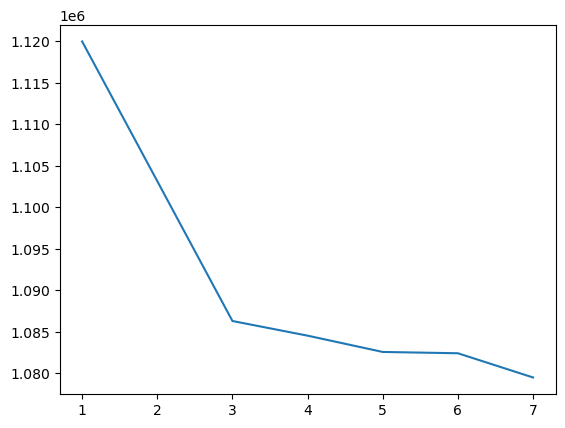

In [100]:
import numpy as np 
import matplotlib.pyplot as plt

y = np.array([i for i in range(1,8,1)])
plt.plot(y,cost)

In [ ]:
## Choosing K=5

In [101]:
km_cao = KModes(n_clusters=5, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(kmeans_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 655, cost: 1082585.0
Run 1, iteration: 2/100, moves: 42, cost: 1082551.0
Run 1, iteration: 3/100, moves: 1, cost: 1082551.0


In [102]:
fitClusters_cao

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [104]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']

In [107]:
# 예측된 클러스터랑 원본데이터 결합시키기.

combinedDf = pd.concat([kMeans_df,clustersDf],axis=1).reset_index(drop=True)

In [108]:
combinedDf.head()

,userID,user_skintype,user_trouble,customer_prd,user_ingredients,cluster_predicted
0,F0002,건성,민감성/아토피,아임쏘리포마이스킨 릴렉싱 앰플&&에이클리어 스팟 포 페이스 세럼&&1025 독도 토...,"병풀잎수,메틸글루세스-20,폴리글리세린-3,병풀추출물,무화과추출물,다시마추출물,한련...",0
1,F0003,복합성,주름/탄력,하이드라메모리 세럼&&멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼&&크림스킨&&포 맨...,"스쿠알란,하이드롤라이즈드효모추출물,하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸타우...",0
2,F0004,중성,잡티/미백/홍조/다크서클,아하 7 화이트헤드 파워 리퀴드&&레티놀 흔적 리페어 앰플&&1번 진정 맑게담은 청...,"사과수,글라이콜릭애씨드,나이아신아마이드,소듐하이드록사이드,판테놀,소듐하이알루로네이트...",0
3,F0005,건성,각질,파이브 플라워 다크스팟 클리어링 세럼&&브링그린 토닝비타20%빛세럼25mL&&화이트...,"글리세레스-26,나이아신아마이드,아크릴레이트/C10-30알킬아크릴레이트크로스폴리머,...",0
4,F0006,중성,트러블,로얄 블랙 스네일 퍼스트 에센스&&모링가 타이트닝 포어 세럼&&레드수딩 시카 밸런스...,"달팽이점액여과물,나이아신아마이드,판테놀,자이모모나스발효추출물,꿀추출물,하이드롤라이즈...",0


## 클러스터된 그룹 분석하기

In [109]:
combinedDf.head()

,userID,user_skintype,user_trouble,customer_prd,user_ingredients,cluster_predicted
0,F0002,건성,민감성/아토피,아임쏘리포마이스킨 릴렉싱 앰플&&에이클리어 스팟 포 페이스 세럼&&1025 독도 토...,"병풀잎수,메틸글루세스-20,폴리글리세린-3,병풀추출물,무화과추출물,다시마추출물,한련...",0
1,F0003,복합성,주름/탄력,하이드라메모리 세럼&&멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼&&크림스킨&&포 맨...,"스쿠알란,하이드롤라이즈드효모추출물,하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸타우...",0
2,F0004,중성,잡티/미백/홍조/다크서클,아하 7 화이트헤드 파워 리퀴드&&레티놀 흔적 리페어 앰플&&1번 진정 맑게담은 청...,"사과수,글라이콜릭애씨드,나이아신아마이드,소듐하이드록사이드,판테놀,소듐하이알루로네이트...",0
3,F0005,건성,각질,파이브 플라워 다크스팟 클리어링 세럼&&브링그린 토닝비타20%빛세럼25mL&&화이트...,"글리세레스-26,나이아신아마이드,아크릴레이트/C10-30알킬아크릴레이트크로스폴리머,...",0
4,F0006,중성,트러블,로얄 블랙 스네일 퍼스트 에센스&&모링가 타이트닝 포어 세럼&&레드수딩 시카 밸런스...,"달팽이점액여과물,나이아신아마이드,판테놀,자이모모나스발효추출물,꿀추출물,하이드롤라이즈...",0


In [110]:
# 5개 그룹
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]
cluster_3 = combinedDf[combinedDf['cluster_predicted'] == 3]
cluster_4 = combinedDf[combinedDf['cluster_predicted'] == 4]

In [121]:
# 각 그룹의 회원수
print(len(cluster_0),len(cluster_1),len(cluster_2),len(cluster_3),len(cluster_4),sep='\n')

## 문제점: 클러스터1그룹에 90%가 넘는 회원이 들어가서, 의미있는 클러스터링이라고 보기 어렵다. 
#          클러스터1 그룹을 분석해보자.

9288
292
314
47
58


In [122]:
cluster_0.head()

,userID,user_skintype,user_trouble,customer_prd,user_ingredients,cluster_predicted
0,F0002,건성,민감성/아토피,아임쏘리포마이스킨 릴렉싱 앰플&&에이클리어 스팟 포 페이스 세럼&&1025 독도 토...,"병풀잎수,메틸글루세스-20,폴리글리세린-3,병풀추출물,무화과추출물,다시마추출물,한련...",0
1,F0003,복합성,주름/탄력,하이드라메모리 세럼&&멀티-펩타이드 + 카퍼 펩타이즈 1% 세럼&&크림스킨&&포 맨...,"스쿠알란,하이드롤라이즈드효모추출물,하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸타우...",0
2,F0004,중성,잡티/미백/홍조/다크서클,아하 7 화이트헤드 파워 리퀴드&&레티놀 흔적 리페어 앰플&&1번 진정 맑게담은 청...,"사과수,글라이콜릭애씨드,나이아신아마이드,소듐하이드록사이드,판테놀,소듐하이알루로네이트...",0
3,F0005,건성,각질,파이브 플라워 다크스팟 클리어링 세럼&&브링그린 토닝비타20%빛세럼25mL&&화이트...,"글리세레스-26,나이아신아마이드,아크릴레이트/C10-30알킬아크릴레이트크로스폴리머,...",0
4,F0006,중성,트러블,로얄 블랙 스네일 퍼스트 에센스&&모링가 타이트닝 포어 세럼&&레드수딩 시카 밸런스...,"달팽이점액여과물,나이아신아마이드,판테놀,자이모모나스발효추출물,꿀추출물,하이드롤라이즈...",0


In [125]:
cluster_0.groupby('user_skintype')['userID'].count()

user_skintype
건성     1832
민감성    1816
복합성    1844
중성     1886
지성     1910
Name: userID, dtype: int64

In [126]:
cluster_0.groupby('user_trouble')['userID'].count()

user_trouble
각질               1543
민감성/아토피          1567
블랙헤드/모공          1550
잡티/미백/홍조/다크서클    1579
주름/탄력            1529
트러블              1520
Name: userID, dtype: int64

In [ ]:
## 성분 분석 들어가자..

In [127]:
# 첫 번째 그룹의 frequency_encoding한 성분 열 중, 0 초과인 열 :: 즉, 클러스터링시, 영향을 준 열
display(clusterCentroidsDf.iloc[0][clusterCentroidsDf.iloc[0].values > 0])

user_ingredients_잔탄검                                   5
user_ingredients_다이소듐이디티에이                             5
user_ingredients_나이아신아마이드                              5
user_ingredients_하이드록시에틸아크릴레이트/소듐아크릴로일다이메틸타우레이트코폴리머    1
user_ingredients_토코페롤                                  5
user_ingredients_베타인                                   3
user_ingredients_아데노신                                  5
user_ingredients_하이드로제네이티드레시틴                          5
user_ingredients_트로메타민                                 5
user_ingredients_소듐하이알루로네이트                            9
user_ingredients_에틸헥실글리세린                              8
user_ingredients_카보머                                   5
user_ingredients_판테놀                                   8
user_ingredients_알란토인                                  4
Name: 0, dtype: int32

In [131]:
kmeans_clust = pd.concat([kmeans_clust,clustersDf],axis=1)
kmeans_clust.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,user_ingredients_프롤린,user_ingredients_수용성엘라스틴,user_ingredients_하이드록시페닐프로파미도벤조익애씨드,user_ingredients_트라이라우레스-4포스페이트,user_ingredients_에틸헥실스테아레이트,user_ingredients_하이드롤라이즈드루핀프로테인,user_ingredients_푸른연꽃추출물,user_ingredients_씨홀리추출물,user_ingredients_소엽맥문동뿌리추출물,cluster_predicted
0,True,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,True,False,False,False,False,False,False,True,...,4,0,0,0,0,0,0,0,0,0
2,False,False,False,True,False,False,False,False,True,False,...,0,0,0,0,2,0,0,0,0,0
3,True,False,False,False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [133]:
cluster_0_df = kmeans_clust[kmeans_clust['cluster_predicted']==0]
cluster_0_df.head()

,user_skintype_건성,user_skintype_민감성,user_skintype_복합성,user_skintype_중성,user_skintype_지성,user_trouble_각질,user_trouble_민감성/아토피,user_trouble_블랙헤드/모공,user_trouble_잡티/미백/홍조/다크서클,user_trouble_주름/탄력,...,user_ingredients_프롤린,user_ingredients_수용성엘라스틴,user_ingredients_하이드록시페닐프로파미도벤조익애씨드,user_ingredients_트라이라우레스-4포스페이트,user_ingredients_에틸헥실스테아레이트,user_ingredients_하이드롤라이즈드루핀프로테인,user_ingredients_푸른연꽃추출물,user_ingredients_씨홀리추출물,user_ingredients_소엽맥문동뿌리추출물,cluster_predicted
0,True,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,True,False,False,False,False,False,False,True,...,4,0,0,0,0,0,0,0,0,0
2,False,False,False,True,False,False,False,False,True,False,...,0,0,0,0,2,0,0,0,0,0
3,True,False,False,False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [134]:
cluster_0_df['user_ingredients_잔탄검']

# 문제점: 5개제품들 성분 합칠 때, 잘못 들어간 것 같다. 전처리 문제가 있다.

0        8
1       13
2        6
3        0
4        4
        ..
9994     4
9995     5
9996    11
9997     9
9998     1
Name: user_ingredients_잔탄검, Length: 9288, dtype: int64

---

---